# Notebook used to predict and quantifiy morphological parameters from phase contrast images of <i>S. suis
----------------------------------------------------------------------------------------------------

## Load dependencies

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
#%matplotlib inlineconfig InlineBackend.figure_format = 'retina'
import pandas as pd
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage import img_as_float32, img_as_ubyte, img_as_float

import time
from glob import glob
import pathlib
import os
from tqdm import tqdm
from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D

np.random.seed(6)
lbl_cmap = random_label_cmap()

# For sliders and dropdown menu and progress bar
from ipywidgets import interact
import ipywidgets as widgets

In [2]:
# show test images
if False:
    fig, ax = plt.subplots(7,8, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x,cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Define output folders


In [3]:
# Define path containing the input
image_path = '/Data/MapZ/TestData/Images'


#Create a results folder and check if the folder already exist
if os.path.exists('/Data/MapZ/TestData/Results') == False:
  os.makedirs('/Datea/MapZ/TestData/Results')

results_path = '/Datea/MapZ/TestData/Results'

# Load StarDist models

We assume that aStarDist model has already been trained via notebook [1_training.ipynb](1_training.ipynb).

In [4]:
# Define model
model_name = 'stardist_5'
model_path = "/DL/stardist2/models"
model_folder = "/DL/stardist2/models/stardist_5" #@param {type:"string"}

print("The "+model_name+" network will be used for prediction")
print('')

# Load model
model = StarDist2D(None, name=model_name, basedir=model_path)

The stardist_5 network will be used for prediction

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.409794, nms_thresh=0.3.


## Prediction of masks and quantitification of defined paramaters

1. Load image stacks (single images for each strain have been combined to stacks in ImageJ) and normalize
2. Predict objects
3. Quantifiy defined parameter using regionprops (skimage package)


In [5]:
t = time.process_time()

# normalize channels independently
axis_norm = (0,1) 

# define regionprops measurements
properties = ['major_axis_length', 'minor_axis_length', 'area', 'perimeter']

for image in os.listdir(image_path):
    print("Performing prediction on: "+image)
    
    short_name = os.path.splitext(image)  

    timelapse = imread(image_path+"/"+image)   
    
    timelapse = normalize(timelapse, 1,99.8, axis=(0,)+tuple(1+np.array(axis_norm)))

    table_stack = pd.DataFrame()
    
    n_images = timelapse.shape[0]
    prediction_stack = np.empty((n_images, timelapse.shape[1], timelapse.shape[2]), dtype='uint16')
    table_temp = pd.DataFrame()
    for t in tqdm(range(n_images), position = 0, leave = True):
        img_t = timelapse[t]
        labels, polygons = model.predict_instances(img_t)#, n_tiles=model._guess_n_tiles(img), show_tile_progress=False)
        clear_border(labels, in_place=True)
        prediction_stack[t] = labels
        tables = regionprops_table(prediction_stack[t], properties=properties) 
        table = pd.DataFrame(tables)
        table = table * (0.0645) # adjust this value according to the pixel size for your microscope/objective
        table_stack = table_stack.append(table)

    table_stack.to_csv(results_path + "/" + str(short_name[0]) + '.csv', index=True, header=True)
    
    #image_stack = img_as_float32(prediction_stack, force_copy=False)
    imsave(results_path + "/" + str(short_name[0]) + '_masks.tif', prediction_stack, imagej=True,
                resolution=(1./0.0645, 1./0.0645), metadata={'spacing': 1.00, 'unit': 'micron', 'axes': 'ZYX'})
    
    
elapsed_time = time.process_time() - t
print('')
print('------------------------------------------------------------')   
print('Time elapsed (hh:mm:ss.ms):', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

  0%|          | 0/9 [00:00<?, ?it/s]

Performing prediction on: 200805_c0375_1_100x_masks.tif


  0%|          | 0/9 [00:00<?, ?it/s]

Performing prediction on: 200805_c0375_2_100x_masks.tif


100%|██████████| 9/9 [00:02<00:00,  3.22it/s]


Performing prediction on: 200805_c0375_1_100x.tif


  0%|          | 0/9 [00:00<?, ?it/s]

Performing prediction on: 200805_c0375_2_100x.tif


100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


------------------------------------------------------------
Time elapsed (hh:mm:ss.ms): 00:00:30


Show some exemplary predicted masks

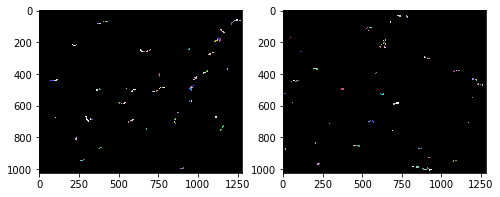

In [6]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(prediction_stack[0], cmap=lbl_cmap)#; plt.colorbar(fraction=0.046, pad=0.04)
ax[1].imshow(prediction_stack[1], cmap=lbl_cmap)
plt.show()

Print measurements from last image

In [7]:
print(table_stack)

    major_axis_length  minor_axis_length     area  perimeter
0            0.694336           0.498474   4.1280   1.868601
1            1.342518           0.897985  12.8355   3.995203
2            0.793851           0.556765   5.3535   2.073168
3            0.599637           0.460491   3.2895   1.670517
4            1.337457           0.935723  14.2545   3.721552
..                ...                ...      ...        ...
56           1.133135           0.748682  10.3200   2.976168
57           1.449366           0.623439  10.9650   3.341035
58           0.939572           0.747007   8.5140   2.642601
59           1.095484           0.652188   8.6430   2.749468
60           1.370600           0.755000  11.9970   3.470035

[499 rows x 4 columns]
